# SARMAX Forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
#from sktime.forecasting import arima
%load_ext autoreload 
%autoreload 2
import functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Model

In [3]:
# load the dataset
dataset = pd.read_csv('training_data.csv')
# dropp unncecassary columns
dataset = dataset.drop(['Unnamed: 0'], axis = 1)
dataset.head()

,epoch_utc,emission_factor,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,298.240217,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,266.522473,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,262.594215,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,260.190772,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,250.496683,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


In [4]:
# Split dataset int targe = co2 emisssions and features

# get co2 emissions
co2 = dataset['emission_factor']

# get features
cols_features = [c for c in dataset.columns if c != 'emission_factor']
cols = {c: i for i, c in enumerate(dataset.columns)}
indices = {ind: i for i, ind in enumerate(dataset.index)}
features = dataset.loc[:, [j for j in cols if j != 'emission_factor' and j in cols_features]]

In [5]:
# check co2 data
co2.head()

0    298.240217
1    266.522473
2    262.594215
3    260.190772
4    250.496683
Name: emission_factor, dtype: float64

In [6]:
# check features
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,DK_import,DK_export,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,901.0,0.0,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,316.0,0.0,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,0.0,405.0,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,0.0,619.0,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,0.0,689.0,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0


## Feature Enginnering

### Create lagged features

In [7]:
# create 26 laggs of the co2 emission factor

co2_lag = fun.make_lags(co2, lags = 125)
co2_lag = co2_lag.fillna(0.0)
co2_lag.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,...,y_lag_116,y_lag_117,y_lag_118,y_lag_119,y_lag_120,y_lag_121,y_lag_122,y_lag_123,y_lag_124,y_lag_125
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,298.240217,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,266.522473,298.240217,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,262.594215,266.522473,298.240217,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,260.190772,262.594215,266.522473,298.240217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# add lag 24 and 26 to the features

#features[['co2_24_lag', 'co2_26_lag','co2_46_lag','co2_48_lag','co2_72_lag','co2_74_lag','co2_96_lag','co2_98_lag','co2_120_lag','co2_122_lag']] = co2_lag[['y_lag_24','y_lag_26','y_lag_46','y_lag_48','y_lag_72','y_lag_74','y_lag_96','y_lag_98','y_lag_120','y_lag_122' ]].set_index(features.index)
#features.head()

In [9]:
# add lag 24 and 26 to the features

#features[['co2_24_lag', 'co2_26_lag','co2_46_lag','co2_48_lag','co2_72_lag','co2_74_lag','co2_96_lag','co2_98_lag','co2_120_lag','co2_122_lag']] = co2_lag[['y_lag_24','y_lag_26','y_lag_46','y_lag_48','y_lag_72','y_lag_74','y_lag_96','y_lag_98','y_lag_120','y_lag_122' ]].set_index(features.index)
#features.head()

In [10]:
# add lag 24 and 26 to the features

features[['co2_24_lag', 'co2_26_lag']] = co2_lag[['y_lag_24','y_lag_26']].set_index(features.index)
features.head()

,epoch_utc,datetime_de,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,...,LU_import,LU_export,NL_import,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag
0,1.546297e+09,2018-12-31 23:00:00+00:00,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,...,12.0,418.0,0.0,1354.0,224.0,0.0,0.0,800.0,0.0,0.0
1,1.546301e+09,2019-01-01 00:00:00+00:00,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,...,16.0,398.0,0.0,1158.0,0.0,0.0,1.0,801.0,0.0,0.0
2,1.546304e+09,2019-01-01 01:00:00+00:00,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,...,19.0,379.0,0.0,1176.0,0.0,0.0,0.0,800.0,0.0,0.0
3,1.546308e+09,2019-01-01 02:00:00+00:00,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,...,23.0,373.0,0.0,1428.0,0.0,0.0,0.0,800.0,0.0,0.0
4,1.546312e+09,2019-01-01 03:00:00+00:00,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,...,27.0,370.0,0.0,1492.0,0.0,0.0,0.0,800.0,0.0,0.0


### Create temproal features

In [11]:
# get datetime type timestemps from fetures
date =pd.to_datetime(features.datetime_de)

In [12]:
# one hot encoding of timestemps of features

features['hour_of_day'] = date.dt.hour # get hour of the given day
features['day_of_week'] = date.dt.weekday # get day of current weak
features['hour_of_year'] = ((date.dt.dayofyear-1) * 24) + date.dt.hour # get hour of current year
features = features.drop(columns=['datetime_de', 'epoch_utc']) # drop the timestemps
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,NL_export,PL_import,PL_export,CH_import,CH_export,co2_24_lag,co2_26_lag,hour_of_day,day_of_week,hour_of_year
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1354.0,224.0,0.0,0.0,800.0,0.0,0.0,23,0,8759
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,1158.0,0.0,0.0,1.0,801.0,0.0,0.0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,1176.0,0.0,0.0,0.0,800.0,0.0,0.0,1,1,1
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,1428.0,0.0,0.0,0.0,800.0,0.0,0.0,2,1,2
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,1492.0,0.0,0.0,0.0,800.0,0.0,0.0,3,1,3


In [13]:
features['day_of_week'].replace({0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'}, inplace=True)
features = pd.get_dummies(features, columns=['day_of_week'])
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,co2_26_lag,hour_of_day,hour_of_year,day_of_week_fri,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,0.0,23,8759,0,1,0,0,0,0,0
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0.0,0,0,0,0,0,0,0,1,0
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0.0,1,1,0,0,0,0,0,1,0
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0.0,2,2,0,0,0,0,0,1,0
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0.0,3,3,0,0,0,0,0,1,0


In [14]:
# transform hourly features into ciclical data

features_temp = ['hour_of_day', 'hour_of_year']
corr_numbers = [24, 8760]# hours in a day and hours in a year
for f, n in zip(features_temp, corr_numbers):
    features[f + '_sin'] = np.sin(features[f]*(2.*np.pi/n))
    features[f + '_cos'] = np.cos(features[f]*(2.*np.pi/n))
features.drop(columns=features_temp, inplace=True)
features.head()

,windon_forecast,windoff_forecast,solar_forecast,prices_forecast,aggregated_generation_forecast,AT_import,AT_export,CZ_import,CZ_export,DK_import,...,day_of_week_mon,day_of_week_sat,day_of_week_sun,day_of_week_thu,day_of_week_tue,day_of_week_wed,hour_of_day_sin,hour_of_day_cos,hour_of_year_sin,hour_of_year_cos
0,18879.75,5069.00,0.0,28.32,57054.0,61.0,4940.0,1076.0,569.0,901.0,...,1,0,0,0,0,0,-0.258819,0.965926,-0.000717,1.000000
1,20626.50,5042.25,0.0,10.07,57400.0,60.0,5073.0,514.0,694.0,316.0,...,0,0,0,0,1,0,0.000000,1.000000,0.000000,1.000000
2,22355.50,5028.50,0.0,-4.08,57275.0,20.0,4284.0,0.0,685.0,0.0,...,0,0,0,0,1,0,0.258819,0.965926,0.000717,1.000000
3,24032.50,4977.75,0.0,-9.91,58024.0,3.0,4273.0,111.0,1186.0,0.0,...,0,0,0,0,1,0,0.500000,0.866025,0.001435,0.999999
4,25452.00,4907.25,0.0,-7.41,59301.0,0.0,4961.0,0.0,1122.0,0.0,...,0,0,0,0,1,0,0.707107,0.707107,0.002152,0.999998


In [15]:
#features = features.drop(columns= ['day_of_week_mon','day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri'])
#features.head()

### Train Test Split

In [16]:
# define the percentage of the train set
train_ratio = 0.7
val_ratio = 0.9
n = len(co2)#
assert(n == len(features))

# split the target into train and test set
co2_train = co2[0:int(n*train_ratio)]
co2_train_val = co2[0:int(n*val_ratio)]
co2_val = co2[int(n*train_ratio):int(n*val_ratio)]
co2_test = co2[int(n*val_ratio):]

# split the features into train and test set
features_train = features[0:int(n*train_ratio)]
features_train_val = features[0:int(n*val_ratio)]
features_val = features[int(n*train_ratio):int(n*val_ratio)]
features_test = features[int(n*val_ratio):]

assert( len(co2_train) == len(features_train))
assert( len(co2_train_val) == len(features_train_val))
assert( len(co2_val) == len(features_val))
assert( len(co2_test) == len(features_test))

In [17]:
#get number of features
n_features = len(features.columns)
print(n_features)

32


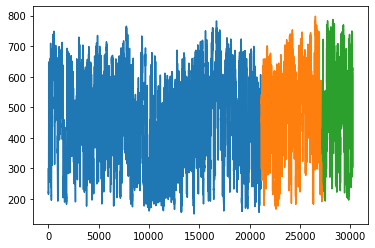

In [18]:
# check the train test split by plotting both

plt.plot(co2_train)
plt.plot(co2_val)
plt.plot(co2_test)
plt.show()

## Create walk forward split

In [19]:
n_val = co2_val.shape[0]
val_split = 8
val_len = n_val // val_split
assert( n_val % val_split == 0)
print('This is the length of the validation data set:', n_val)
print('This is the number of validation splits:', val_split)
print('This is the length of one validation split:', val_len)


This is the length of the validation data set: 6048
This is the number of validation splits: 8
This is the length of one validation split: 756


# Linear Regression

In [20]:
# Define the  Linear Regression model
regr = LinearRegression( )


In [20]:
# make a walking forward prediction with the Linear Regression model# av

forecast_period = 24
pred_LR,report_LR = fun.walk_forward_ML(features_train_val ,features_test,co2_train_val,co2_test,regr,forecast_period,'Linear_Regression')
print(report_LR)

MAE for Linear_Regression: 42.37 g_CO2/kWh
MAPE for Linear_Regression: 9.87 %
RMSE for Linear_Regression: 52.99 g_CO2/kWh
R2 Linear_Regression: 87.33 %


In [19]:
# save the predictions in a DataFame

pred_LR_df = pd.DataFrame(pred_LR)
pred_LR_df.index = co2[int(n*val_ratio):].index
pred_LR_df.head()

,0
27215,322.468404
27216,318.632056
27217,304.110974
27218,286.351534
27219,277.889266


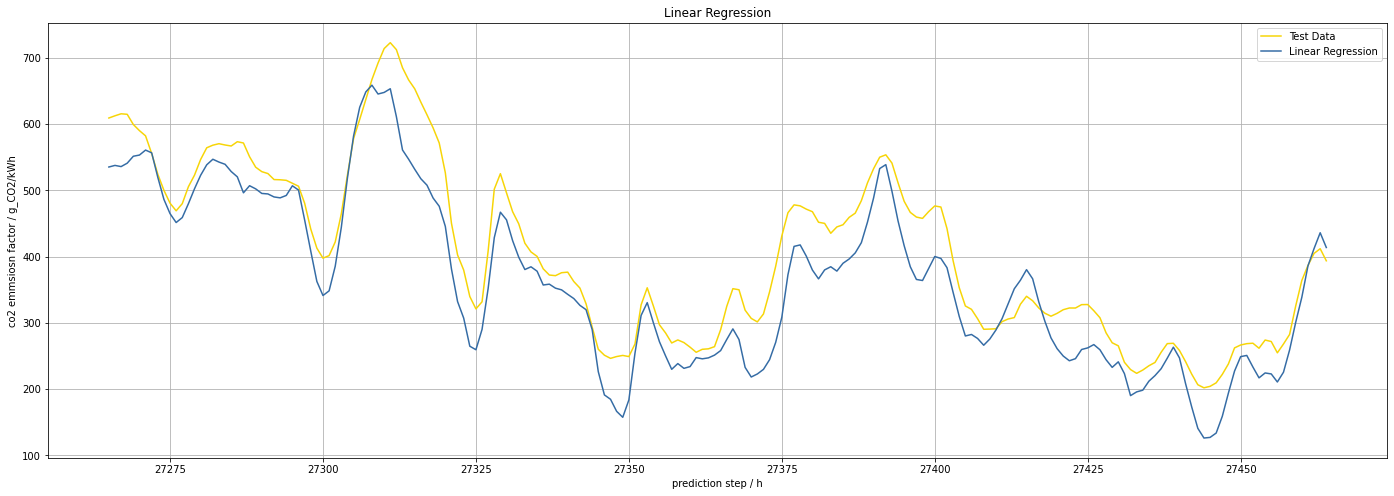

In [20]:
# Plot prediction vs. test value

fun.plot_model(co2_test, pred_LR_df, 50, 250, 'Linear Regression')

## Linearity test

In [21]:
from statsmodels.regression import linear_model 
from statsmodels.stats.diagnostic import linear_reset

In [22]:
# fit a Linear Regression model

reg = linear_model.OLS(co2,features).fit()

In [23]:
# Check if the relationship between fetures and target can be described linearly

linear = linear_reset(reg)

d:\ABajrami\thesis\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [24]:
# print the results
print(linear.summary)
print(round(linear.pvalue,4))

<bound method ContrastResults.summary of <class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=2621.497659474863, p-value=0.0, df_denom=2>>
0.0


## SARIMAX

### Do a Grid Search on train set

In [23]:
import pmdarima as pm

In [24]:
# unccomment for shorter time frame for grid search


#co2_train_short = co2[0:int(0.05*len(co2))]
#features_train_short = features[0:int(0.05*len(co2))]
#co2_train_short.shape, features_train_short.shape

In [25]:
# Do a Grid Search with pmdarima 

model_sarma_auto = pm.auto_arima(co2_train, exogenous = features_train, 
                      start_p=3, start_q=1,
                      #test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=24,              # frequency of series
                      d=0,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=1, start_Q=1,
                      max_P= 2, max_Q= 2,
                      D=0, 
                      trace=True,
                      stationary = True, 
                      error_action='trace',  
                      suppress_warnings=False, 
                      stepwise=True,
                      #n_jobs = 6,
                      return_valid_fits= True,
                      max_order= None,
                      maxiter = 15
                        )
print(model_sarma_auto.summary())

Performing stepwise search to minimize aic


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,0,1)[24] intercept   : AIC=158445.997, Time=332.28 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=216704.814, Time=32.71 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=163935.086, Time=437.54 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=212695.314, Time=520.24 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=406364.339, Time=39.08 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(0,0,1)[24] intercept   : AIC=158919.126, Time=567.14 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,0,0)[24] intercept   : AIC=159203.146, Time=679.41 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,0,1)[24] intercept   : AIC=158584.996, Time=13634.91 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(1,0,2)[24] intercept   : AIC=158339.361, Time=14480.84 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(0,0,2)[24] intercept   : AIC=158589.347, Time=6986.15 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,1)(2,0,2)[24] intercept   : AIC=158208.463, Time=8665.47 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,0,2)[24] intercept   : AIC=158193.780, Time=8085.45 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,0,2)[24] intercept   : AIC=158328.835, Time=9345.56 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,0,1)[24] intercept   : AIC=158576.696, Time=8734.67 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(1,0,1)[24] intercept   : AIC=158450.046, Time=286.93 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,1)(2,0,2)[24] intercept   : AIC=158826.996, Time=8931.86 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,0)(2,0,2)[24] intercept   : AIC=158222.233, Time=9145.67 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,2)(2,0,2)[24] intercept   : AIC=158199.470, Time=9274.74 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=162947.895, Time=7004.56 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(1,0,2)(2,0,2)[24] intercept   : AIC=158274.141, Time=8218.58 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,0)(2,0,2)[24] intercept   : AIC=158199.513, Time=8035.40 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(3,0,2)(2,0,2)[24] intercept   : AIC=158201.101, Time=8584.35 sec


d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(2,0,1)(2,0,2)[24]             : AIC=158195.402, Time=7554.86 sec

Best model:  ARIMA(2,0,1)(2,0,2)[24] intercept
Total fit time: 139578.488 seconds


AttributeError: 'tuple' object has no attribute 'summary'

In [29]:

# describe best model results
model_sarma_auto.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

In [30]:
import joblib

In [32]:
joblib.dump(model_sarma_auto, 'grid_search_sarmax.pkl')

['grid_search_sarmax.pkl']

### Wak forward validation

In [21]:
# test on validation data
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train, exog= features_train,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# see reulsts for model
sarmax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         emission_factor   No. Observations:                21167
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood              -78380.622
Date:                                 Mon, 03 Oct 2022   AIC                         156841.245
Time:                                         17:52:35   BIC                         157159.653
Sample:                                              0   HQIC                        156945.133
                                               - 21167                                         
Covariance Type:                                   opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
windon_forecast                   -0.0096      0.000    -77.873      0.000      -0.010      -0.009
windoff_forecast                  -0.0097      0.000    -27.813      0.000      -0.010      -0.009
solar_forecast                    -0.0108      0.000    -70.249      0.000      -0.011      -0.010
prices_forecast                    0.1491      0.015     10.024      0.000       0.120       0.178
aggregated_generation_forecast     0.0037   6.86e-05     54.021      0.000       0.004       0.004
AT_import                          0.0004      0.000      1.158      0.247      -0.000       0.001
AT_export                          0.0003      0.000      1.472      0.141   -8.43e-05       0.001
CZ_import                          0.0005      0.000      1.353      0.176      -0.000       0.001
CZ_export                         -0.0005      0.000     -1.331      0.183      -0.001       0.000
DK_import                          0.0008      0.000      2.961      0.003       0.000       0.001
DK_export                          0.0003      0.000      1.163      0.245      -0.000       0.001
LU_import                         -0.8397      0.010    -83.287      0.000      -0.859      -0.820
LU_export                          0.0529      0.004     12.662      0.000       0.045       0.061
NL_import                          0.0010      0.000      4.438      0.000       0.001       0.002
NL_export                       -8.68e-05      0.000     -0.538      0.591      -0.000       0.000
PL_import                          0.0036      0.001      2.484      0.013       0.001       0.006
PL_export                          0.0014      0.001      2.165      0.030       0.000       0.003
CH_import                      -7.097e-06      0.000     -0.025      0.980      -0.001       0.001
CH_export                          0.0008      0.000      1.631      0.103      -0.000       0.002
co2_24_lag                         0.0844      0.007     12.485      0.000       0.071       0.098
co2_26_lag                        -0.0177      0.007     -2.448      0.014      -0.032      -0.004
day_of_week_fri                  351.5102      5.494     63.976      0.000     340.741     362.279
day_of_week_mon                  370.7159      5.385     68.839      0.000     360.161     381.271
day_of_week_sat                  332.6074      5.446     61.079      0.000     321.934     343.280
day_of_week_sun                  340.9579      5.386     63.304      0.000     330.401     351.514
day_of_week_thu                  360.0261      5.545     64.931      0.000     349.159     370.894
day_of_week_tue                  365.7872      5.493     66.587      0.000     355.020     376.554
day_of_week_wed                  364.3275      5.532     65.853      0.000     353.484     375.171
hour_of_day_sin    

In [22]:
# select the width of the confidence inverval
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print( 'width of confidence interval:', ci_width)

pred_sarmax_val,report_sarmax_val,lower_sarmax_val,upper_sarmax_val = fun.walk_forward_validation_sarimax(features_val, co2_val, val_len, sarmax_fit,alpha_low,alpha_high,n_features, 'SARMAX', refit = False)
print(report_sarmax_val)

width of confidence interval: 0.95
MAE for SARMAX: 45.56 g_CO2/kWh
MAPE for SARMAX: 9.4 %
RMSE for SARMAX: 56.15 g_CO2/kWh
Pinball for lower Quantile SARMAX: 3.14 g_CO2/kWh
Pinball for higher Quantile SARMAX: 3.77 g_CO2/kWh
Interval Score SARMAX: 177.8957 g_CO2/kWh
Real Values insisde PI SARMAX: 87.96 %
R2 SARMAX: 82.19999999999999 %
Adjusted R2 SARMAX: 82.1 %


In [22]:
report_sarmax_val

'MAE for SARMAX: 89.16 g_CO2/kWh\nMAPE for SARMAX: 18.22 %\nRMSE for SARMAX: 103.4 g_CO2/kWh\nPinball for lower Quantile SARMAX: 5.41 g_CO2/kWh\nPinball for higher Quantile SARMAX: 7.82 g_CO2/kWh\nInterval Score SARMAX: 277.9144 g_CO2/kWh\nReal Values insisde PI SARMAX: 79.33 %\nR2 SARMAX: 39.629999999999995 %\nAdjusted R2 SARMAX: 39.36 %'

In [23]:
pred_sarmax_val_df = pd.DataFrame(pred_sarmax_val)
pred_sarmax_val_df.head()

,0
0,509.629679
1,498.923434
2,483.672105
3,483.517003
4,492.002259


In [24]:
lower_val_df = pd.DataFrame(lower_sarmax_val)
lower_val_df

,0
0,487.682494
1,460.835158
2,433.608609
3,424.768110
4,426.957508
...,...
6043,302.251586
6044,305.524251
6045,298.897918
6046,286.839324


In [25]:
upper_val_df = pd.DataFrame(upper_sarmax_val)
upper_val_df

,0
0,531.576864
1,537.011711
2,533.735600
3,542.265896
4,557.047010
...,...
6043,475.713408
6044,478.986073
6045,472.359739
6046,460.301145


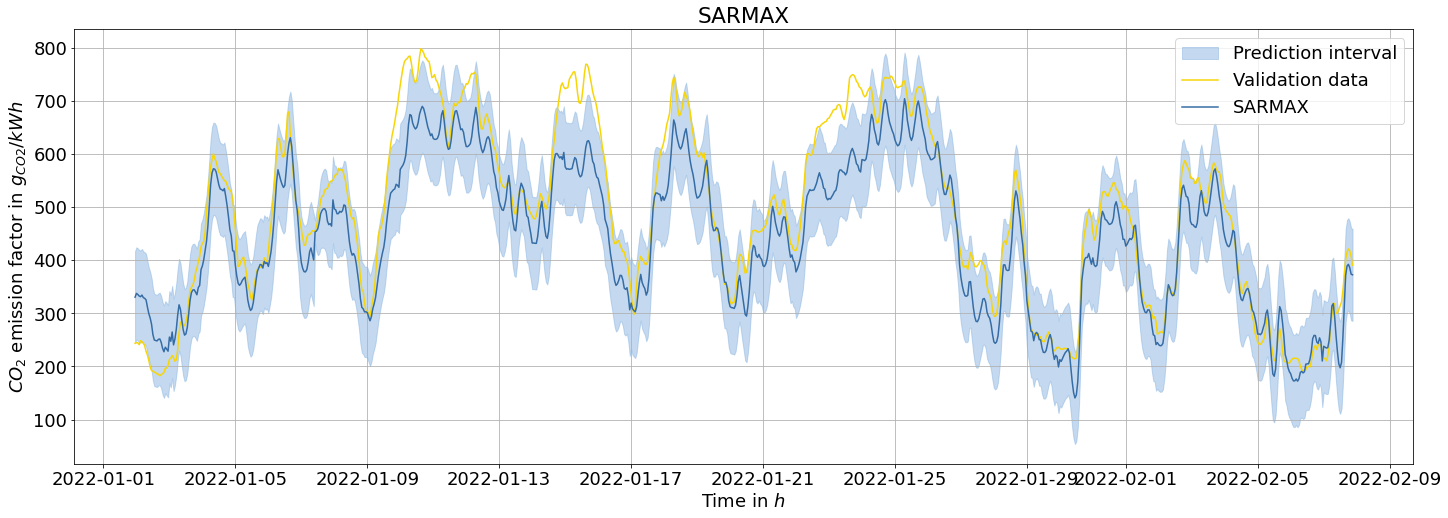

In [30]:
fun.plot_model_uncertainty2(co2_val, pred_sarmax_val_df,lower_val_df ,upper_val_df, date_val, slice_start = '2022-01-01 23:00', slice_end =  '2022-02-15 23:00' , method = 'SARMAX')

### Test on test data

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
forecast_period =24
config_sarma = (2,0,1)
seasonal_config = (2,0,2,forecast_period)
sarmax = SARIMAX(endog = co2_train_val, exog= features_train_val,  order = config_sarma, seasonal_order  = seasonal_config)
sarmax_fit= sarmax.fit()

d:\ABajrami\thesis\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
sarmax_fit.test_heteroskedasticity(method = None)

array([[0.97145354, 0.16783228]])

In [33]:
# see reulsts for model
sarmax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                         emission_factor   No. Observations:                27215
Model:             SARIMAX(2, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood             -100287.154
Date:                                 Mon, 10 Oct 2022   AIC                         200654.308
Time:                                         16:46:07   BIC                         200982.769
Sample:                                              0   HQIC                        200760.189
                                               - 27215                                         
Covariance Type:                                   opg                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
windon_forecast                   -0.0094      0.000    -86.279      0.000      -0.010      -0.009
windoff_forecast                  -0.0119      0.000    -39.386      0.000      -0.012      -0.011
solar_forecast                    -0.0106      0.000    -77.668      0.000      -0.011      -0.010
prices_forecast                    0.0344      0.010      3.615      0.000       0.016       0.053
aggregated_generation_forecast     0.0036   6.23e-05     57.398      0.000       0.003       0.004
AT_import                         -0.0004      0.000     -1.136      0.256      -0.001       0.000
AT_export                          0.0006      0.000      4.371      0.000       0.000       0.001
CZ_import                          0.0005      0.000      1.394      0.163      -0.000       0.001
CZ_export                          0.0007      0.000      2.094      0.036    4.24e-05       0.001
DK_import                          0.0009      0.000      3.695      0.000       0.000       0.001
DK_export                          0.0005      0.000      1.775      0.076   -5.08e-05       0.001
LU_import                         -0.8567      0.009    -91.917      0.000      -0.875      -0.838
LU_export                          0.0728      0.003     21.462      0.000       0.066       0.079
NL_import                          0.0009      0.000      4.166      0.000       0.000       0.001
NL_export                       2.648e-05      0.000      0.175      0.861      -0.000       0.000
PL_import                          0.0017      0.001      3.094      0.002       0.001       0.003
PL_export                          0.0007      0.001      1.278      0.201      -0.000       0.002
CH_import                         -0.0005      0.000     -1.924      0.054      -0.001    9.06e-06
CH_export                         -0.0011      0.000     -2.594      0.009      -0.002      -0.000
co2_24_lag                         0.0934      0.006     14.766      0.000       0.081       0.106
co2_26_lag                        -0.0076      0.007     -1.145      0.252      -0.021       0.005
day_of_week_fri                  353.8718      5.059     69.949      0.000     343.956     363.787
day_of_week_mon                  372.1672      4.969     74.892      0.000     362.427     381.907
day_of_week_sat                  336.5775      5.022     67.023      0.000     326.735     346.420
day_of_week_sun                  344.0742      4.970     69.227      0.000     334.333     353.816
day_of_week_thu                  360.7226      5.099     70.748      0.000     350.729     370.716
day_of_week_tue                  365.5546      5.059     72.264      0.000     355.640     375.469
day_of_week_wed                  364.0830      5.089     71.539      0.000     354.108     374.058
hour_of_day_sin    

In [34]:
# select the width of the confidence inverval
alpha_low = 0.025
alpha_high = 0.975
ci_width = alpha_high - alpha_low
print( 'width of confidence interval:', ci_width)

pred_sarmax_test,report_sarmax_test,lower_sarmax_test,upper_sarmax_test = fun.walk_forward_validation_sarimax(features_test, co2_test, forecast_period, sarmax_fit,alpha_low,alpha_high,n_features, 'SARMAX', refit = False)
print(report_sarmax_test)

width of confidence interval: 0.95
MAE for SARMAX: 39.76 g_CO2/kWh
MAPE for SARMAX: 8.290000000000001 %
RMSE for SARMAX: 49.68 g_CO2/kWh
Pinball for lower Quantile SARMAX: 2.74 g_CO2/kWh
Pinball for higher Quantile SARMAX: 3.16 g_CO2/kWh
Interval Score SARMAX: 153.7769 g_CO2/kWh
Real Values insisde PI SARMAX: 88.06 %
R2 SARMAX: 88.87 %
Adjusted R2 SARMAX: 88.75 %


In [32]:
print(report_sarmax_test)

MAE for SARMAX: 39.76 g_CO2/kWh
MAPE for SARMAX: 8.290000000000001 %
RMSE for SARMAX: 49.68 g_CO2/kWh
Pinball for lower Quantile SARMAX: 2.74 g_CO2/kWh
Pinball for higher Quantile SARMAX: 3.16 g_CO2/kWh
Interval Score SARMAX: 153.7769 g_CO2/kWh
Real Values insisde PI SARMAX: 88.06 %
R2 SARMAX: 88.87 %
Adjusted R2 SARMAX: 88.75 %


In [35]:
pred_sarmax_df = pd.DataFrame(pred_sarmax_test)
pred_sarmax_df.to_csv('sarmax_mean_wf_test.csv')
pred_sarmax_df.head()

,0
0,369.296563
1,363.019763
2,339.184612
3,329.561544
4,322.458123


In [36]:
upper_test_df = pd.DataFrame(upper_sarmax_test)
upper_test_df.to_csv('sarmax_upper_wf_test.csv')
upper_test_df.head()

,0
0,391.105660
1,400.965406
2,389.205737
3,388.434510
4,387.826802


In [37]:
lower_test_df = pd.DataFrame(lower_sarmax_test)
lower_test_df.to_csv('sarmax_lower_wf_test.csv')
lower_test_df

,0
0,347.487466
1,325.074120
2,289.163488
3,270.688578
4,257.089444
...,...
3019,407.992284
3020,462.972696
3021,476.145468
3022,485.636057


In [38]:
date_val = date[int(n*train_ratio):int(n*val_ratio)]
date_test = date[int(n*val_ratio):n]

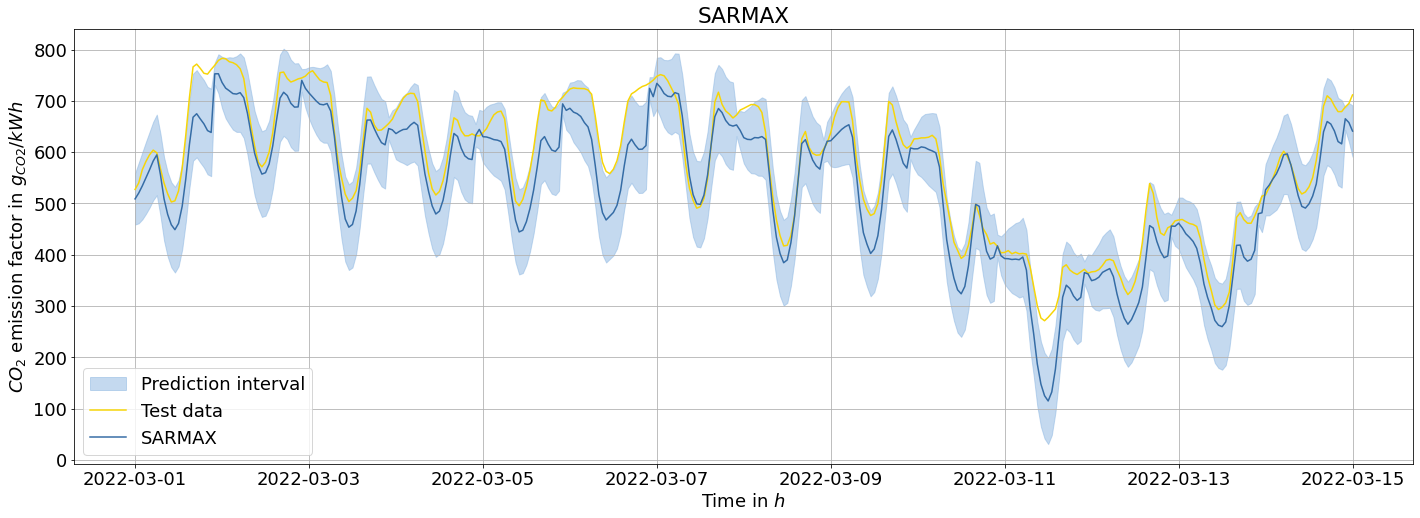

In [39]:
fun.plot_model_uncertainty(co2_test, pred_sarmax_df, lower_test_df , upper_test_df, date_test, '2022-03-01 00:00', '2022-03-15 00:00', 'SARMAX')

In [48]:
# save the model for future usage
joblib.dump(sarmax_fit, 'saramx_model.pkl')

['saramx_model.pkl']